<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/amazon_fashion/fashion_AdapterFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 18 kB/s 
     |████████████████████████████████| 3.9 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 6.6 MB 22.5 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 880 kB 41.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4a65cc969fe663909396278512ba84ade8cfad42631548ac36a2716557b433c5
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 4.6 MB/s 
     |████████████████████████████████| 212 kB 43.4 MB/s 
     |████████████████████████████████| 140 kB 40.1 MB/s 
     |████████████████████████████████|

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load fashion data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/fashion/02_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/fashion/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/fashion/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/fashion/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(530, 3)
 1.0    386
-1.0     98
 0.0     46
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This China Silk Black Balaclava is great for k...
1,1.0,2004,This item is very lightweight (as you'd expect...
2,1.0,2006,This item came in only 2 days and in perfect c...
3,1.0,2006,This ring was well worth the price. It has a l...
4,1.0,2006,"It was exactly as described. Beautiful ring, ..."


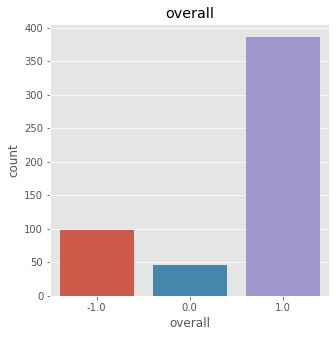

In [ ]:
# load data for 2002 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(16800, 3)
 1.0    12574
-1.0     2657
 0.0     1569
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2012,"I ordered a ladies cigarette case for my wife,..."
1,1.0,2010,Received the case in less than a week...was ve...
2,-1.0,2012,Don't buy this shirt unless you plan to spend ...
3,1.0,2012,"Nice shirt, Well made. good sizing. Nice color..."
4,1.0,2011,If you want a look that takes it back to the O...


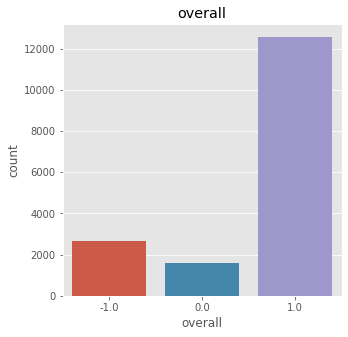

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(614812, 3)
 1.0    413534
-1.0    130175
 0.0     71103
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,Exactly what I needed.
1,-1.0,2014,"I agree with the other review, the opening is ..."
2,1.0,2014,Love these... I am going to order another pack...
3,-1.0,2014,too tiny an opening
4,0.0,2014,Okay


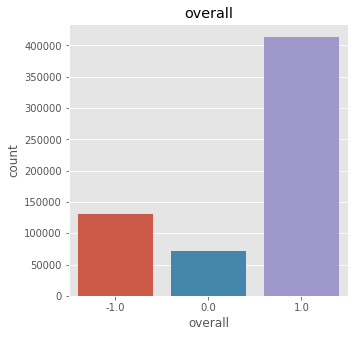

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(47246, 3)
 1.0    33622
-1.0     8865
 0.0     4759
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,Just what I needed for a party
1,1.0,2018,Son loves it. Decent quality.
2,1.0,2018,My son wanted to dress like August Pullman fro...
3,1.0,2018,awesome.
4,1.0,2018,My daughter loves this item. My high score is ...


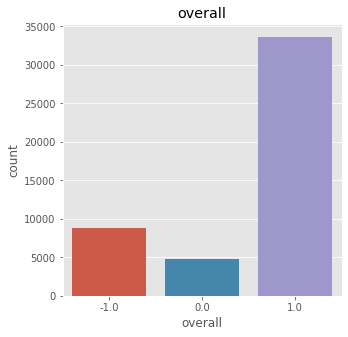

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
6000 positive，2500 negative，1500 neutral except 2002-2006

80%(8000) training and 20%(2000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4800,:]
  train_neudata = neu.iloc[:1200,:]
  train_negdata = neg.iloc[:2000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4800:6000,:]
  test_neudata = neu.iloc[1200:1500,:]
  test_negdata = neg.iloc[2000:2500,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# No data for 2002 - 2006
# df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df1_train,df1_test = split_balance(df2)

# data for 2013 - 2017
df2_train,df2_test = split_balance(df3)

# data for 2018
df3_train,df3_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText
5948,1.0,2012,"Besides being a gorgeous necklace, it came in ..."
0,2.0,2012,"I ordered a ladies cigarette case for my wife,..."
13951,2.0,2012,THIA PRODUCT IS NOT SUITABLE FOR AN ADULT. I ...
14323,1.0,2012,It was a great and beautiful necklace looks li...
11579,1.0,2012,Perfectly propotioned. This was a gift for my ...


## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

## Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 2007-2012

In [ ]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
model.add_adapter("df1")
# Add a matching classification head
model.add_classification_head(
    "reviews",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("df1")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

df1_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df1_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.739600
400,0.594500
600,0.560400
800,0.548500
1000,0.514400
1200,0.513300
1400,0.506000


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df1/pytorch_ada

TrainOutput(global_step=1500, training_loss=0.562884167989095, metrics={'train_runtime': 415.3368, 'train_samples_per_second': 115.569, 'train_steps_per_second': 3.612, 'total_flos': 3212108476416000.0, 'train_loss': 0.562884167989095, 'epoch': 6.0})

In [ ]:
df1_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.788,
 'eval_loss': 0.5177175402641296,
 'eval_runtime': 8.6982,
 'eval_samples_per_second': 229.933,
 'eval_steps_per_second': 7.243}

In [ ]:
df1_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.64118254, -2.680763  ,  1.5401406 ],
       [-1.1888057 ,  3.8951118 , -2.8551548 ],
       [-1.4682757 ,  3.7285173 , -2.5603468 ],
       ...,
       [-1.1083188 ,  2.7655418 , -2.220605  ],
       [-1.1472247 ,  1.5294155 , -0.7800004 ],
       [-1.1136751 ,  3.2036202 , -2.4899888 ]], dtype=float32), label_ids=array([0, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.5659804344177246, 'test_acc': 0.766, 'test_runtime': 8.7098, 'test_samples_per_second': 229.627, 'test_steps_per_second': 7.233})

In [ ]:
df1_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-0.3943401 ,  2.1661685 , -2.4028447 ],
       [-1.1200433 , -0.68451875,  1.7114258 ],
       [-0.04912023, -1.5661113 ,  0.9688398 ],
       ...,
       [-1.1324105 ,  3.5491645 , -2.7687867 ],
       [-1.4092014 ,  4.205395  , -3.022646  ],
       [-0.35404333, -1.243625  ,  1.5812138 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 1, 2]), metrics={'test_loss': 0.5363199710845947, 'test_acc': 0.7785, 'test_runtime': 8.6873, 'test_samples_per_second': 230.222, 'test_steps_per_second': 7.252})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1", "df1")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df1')

### adapter learning from 2013-2017

In [ ]:
model.add_adapter("df2")

Adding adapter 'df2'.


In [ ]:
# Activate the adapter
model.train_adapter("df2")

In [ ]:
df2_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df2_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.719300
400,0.595800
600,0.572300
800,0.543000
1000,0.522400
1200,0.520700
1400,0.492100


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df2/pytorch_ada

TrainOutput(global_step=1500, training_loss=0.5622821731567382, metrics={'train_runtime': 415.0184, 'train_samples_per_second': 115.658, 'train_steps_per_second': 3.614, 'total_flos': 3212108476416000.0, 'train_loss': 0.5622821731567382, 'epoch': 6.0})

In [ ]:
df2_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.785,
 'eval_loss': 0.5516095757484436,
 'eval_runtime': 8.7005,
 'eval_samples_per_second': 229.872,
 'eval_steps_per_second': 7.241}

In [ ]:
df2_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.56699485, -0.66057634, -0.2690408 ],
       [-1.4744134 ,  4.006413  , -2.8511877 ],
       [-1.0952852 ,  1.6841096 , -0.79118836],
       ...,
       [ 0.28036663, -0.52328587,  0.11001834],
       [-1.244482  ,  3.1026359 , -2.0355527 ],
       [ 0.13534658,  0.66079926, -1.0713297 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 1]), metrics={'test_loss': 0.5458609461784363, 'test_acc': 0.7825, 'test_runtime': 8.7101, 'test_samples_per_second': 229.619, 'test_steps_per_second': 7.233})

In [ ]:
df2_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-0.15019082,  1.9637371 , -2.548638  ],
       [-1.5627267 , -1.0759872 ,  2.5723531 ],
       [-0.42895237, -1.1834892 ,  1.2647567 ],
       ...,
       [-1.0335763 ,  4.0579586 , -3.500961  ],
       [-1.3040526 ,  4.9765425 , -4.0347915 ],
       [-0.14431341, -1.5509725 ,  1.6142259 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 1, 2]), metrics={'test_loss': 0.517045259475708, 'test_acc': 0.794, 'test_runtime': 8.6981, 'test_samples_per_second': 229.934, 'test_steps_per_second': 7.243})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2", "df2")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df2')

### adapter learning from 2018

In [ ]:
model.add_adapter("df3")

Adding adapter 'df3'.


In [ ]:
# Activate the adapter
model.train_adapter("df3")

In [ ]:
df3_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
df3_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.711800
400,0.602800
600,0.558100
800,0.556400
1000,0.536900
1200,0.514800
1400,0.527800


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df3/pytorch_ada

TrainOutput(global_step=1500, training_loss=0.567747698465983, metrics={'train_runtime': 414.692, 'train_samples_per_second': 115.749, 'train_steps_per_second': 3.617, 'total_flos': 3212108476416000.0, 'train_loss': 0.567747698465983, 'epoch': 6.0})

In [ ]:
df3_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7945,
 'eval_loss': 0.5075201988220215,
 'eval_runtime': 8.6863,
 'eval_samples_per_second': 230.247,
 'eval_steps_per_second': 7.253}

In [ ]:
df3_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.530511  , -0.80746204,  0.07183272],
       [-1.7229474 ,  3.8620007 , -2.4075205 ],
       [-0.92842615,  1.188513  , -0.4636668 ],
       ...,
       [ 0.25722617, -0.7975307 ,  0.36045867],
       [-1.6883683 ,  3.220025  , -1.7505947 ],
       [ 0.0546794 ,  1.1941819 , -1.5321939 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 1]), metrics={'test_loss': 0.5382750034332275, 'test_acc': 0.787, 'test_runtime': 8.6971, 'test_samples_per_second': 229.962, 'test_steps_per_second': 7.244})

In [ ]:
df3_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.94220424, -2.0760972 ,  0.8404838 ],
       [-1.9626963 ,  5.2102256 , -3.4324455 ],
       [-2.334871  ,  5.16476   , -3.142516  ],
       ...,
       [-1.6385684 ,  4.269123  , -3.1419375 ],
       [-1.2183377 ,  2.064175  , -1.0323547 ],
       [-1.0676259 ,  3.487843  , -2.8211248 ]], dtype=float32), label_ids=array([0, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.5468225479125977, 'test_acc': 0.779, 'test_runtime': 8.6926, 'test_samples_per_second': 230.082, 'test_steps_per_second': 7.248})

In [ ]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3", "df3")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/pytorch_adapter.bin


In [ ]:
model.delete_adapter('df3')

## Adapter Fusion

### learn from 2007-2012

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/pytorch_adapter.bin


'df3'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3"))

Adding AdapterFusion 'df1,df2,df3'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3]'.


In [ ]:
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)

Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3")
model_fu.train_adapter_fusion(adapter_setup)

In [ ]:
fusion_trainer_df1 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.577800
400,0.537600
600,0.515900
800,0.528000
1000,0.490000
1200,0.495900
1400,0.489300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weights saved in ./training_output/checkpoint-500/fusion/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./trainin

TrainOutput(global_step=1500, training_loss=0.5161985219319661, metrics={'train_runtime': 813.3168, 'train_samples_per_second': 59.018, 'train_steps_per_second': 1.844, 'total_flos': 4061497503744000.0, 'train_loss': 0.5161985219319661, 'epoch': 6.0})

In [ ]:
fusion_trainer_df1.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7925,
 'eval_loss': 0.5088220834732056,
 'eval_runtime': 14.0042,
 'eval_samples_per_second': 142.815,
 'eval_steps_per_second': 4.499}

In [ ]:
fusion_trainer_df1.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.9813345 , -2.5621564 ,  1.7336814 ],
       [-1.0902294 ,  4.301188  , -2.8254178 ],
       [-1.2593497 ,  4.1713123 , -2.361958  ],
       ...,
       [-0.5828778 ,  3.2284687 , -2.061516  ],
       [-0.48709455,  1.3311303 , -0.28579998],
       [-0.7645884 ,  3.632334  , -2.3396506 ]], dtype=float32), label_ids=array([0, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.5580611824989319, 'test_acc': 0.774, 'test_runtime': 14.0288, 'test_samples_per_second': 142.564, 'test_steps_per_second': 4.491})

In [ ]:
fusion_trainer_df1.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 7.1135070e-04,  2.2945247e+00, -1.9792682e+00],
       [-1.0450404e+00,  1.3266516e-02,  1.7960968e+00],
       [ 2.7720717e-01, -1.1806849e+00,  1.1048170e+00],
       ...,
       [-6.8362463e-01,  3.4657152e+00, -2.1574686e+00],
       [-1.1223277e+00,  4.2986455e+00, -2.6314139e+00],
       [-1.0315964e-01, -1.6128787e+00,  2.1374373e+00]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 1, 2]), metrics={'test_loss': 0.5199987292289734, 'test_acc': 0.79, 'test_runtime': 14.0283, 'test_samples_per_second': 142.569, 'test_steps_per_second': 4.491})

### learn from 2013-2017

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/pytorch_adapter.bin


'df3'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
fusion_trainer_df2 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.593000
400,0.538500
600,0.548400
800,0.517000
1000,0.510800
1200,0.508800
1400,0.490300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weights saved in ./training_output/checkpoint-500/fusion/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./trainin

TrainOutput(global_step=1500, training_loss=0.5272815399169922, metrics={'train_runtime': 812.9644, 'train_samples_per_second': 59.043, 'train_steps_per_second': 1.845, 'total_flos': 4061497503744000.0, 'train_loss': 0.5272815399169922, 'epoch': 6.0})

In [ ]:
fusion_trainer_df2.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.7885,
 'eval_loss': 0.5520154237747192,
 'eval_runtime': 13.9859,
 'eval_samples_per_second': 143.001,
 'eval_steps_per_second': 4.505}

In [ ]:
fusion_trainer_df2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.5623631 , -0.61766744,  0.05151764],
       [-1.2058499 ,  4.2738113 , -2.6150098 ],
       [-0.7669491 ,  1.7877041 , -0.76912475],
       ...,
       [ 0.33778182, -0.36055514,  0.23339175],
       [-1.1419526 ,  3.414183  , -2.0622768 ],
       [ 0.24148746,  0.72492224, -0.80814415]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 1]), metrics={'test_loss': 0.5393761992454529, 'test_acc': 0.779, 'test_runtime': 13.9784, 'test_samples_per_second': 143.077, 'test_steps_per_second': 4.507})

In [ ]:
fusion_trainer_df2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.03636985,  2.2644296 , -2.0677013 ],
       [-1.4048965 , -0.6881751 ,  2.8050113 ],
       [-0.23944809, -1.2070417 ,  1.6454256 ],
       ...,
       [-0.68142027,  4.11622   , -3.0012918 ],
       [-1.0794115 ,  5.0416284 , -3.4740195 ],
       [-0.2362378 , -1.200841  ,  1.6346422 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 1, 2]), metrics={'test_loss': 0.5168399810791016, 'test_acc': 0.7875, 'test_runtime': 13.9644, 'test_samples_per_second': 143.222, 'test_steps_per_second': 4.511})

### learn from 2018

In [ ]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [ ]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/fashion_3/pytorch_adapter.bin


'df3'

In [ ]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [ ]:
fusion_trainer_df3 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
fusion_trainer_df3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.592300
400,0.556400
600,0.523900
800,0.525200
1000,0.523500
1200,0.501900
1400,0.503200


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weights saved in ./training_output/checkpoint-500/fusion/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./trainin

TrainOutput(global_step=1500, training_loss=0.5295326741536458, metrics={'train_runtime': 812.0885, 'train_samples_per_second': 59.107, 'train_steps_per_second': 1.847, 'total_flos': 4061497503744000.0, 'train_loss': 0.5295326741536458, 'epoch': 6.0})

In [ ]:
fusion_trainer_df3.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.792,
 'eval_loss': 0.5104777216911316,
 'eval_runtime': 13.9873,
 'eval_samples_per_second': 142.986,
 'eval_steps_per_second': 4.504}

In [ ]:
fusion_trainer_df3.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.48858902, -0.54681605,  0.11603314],
       [-1.2869211 ,  4.007406  , -2.2049396 ],
       [-0.40326795,  1.0852234 , -0.34396288],
       ...,
       [ 0.28600818, -0.6978776 ,  0.5062299 ],
       [-1.6084558 ,  3.4721246 , -1.5690846 ],
       [ 0.16175656,  1.1767722 , -1.0630771 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 2, 1, 1]), metrics={'test_loss': 0.5311060547828674, 'test_acc': 0.788, 'test_runtime': 13.9565, 'test_samples_per_second': 143.302, 'test_steps_per_second': 4.514})

In [ ]:
fusion_trainer_df3.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 1.1043375 , -1.9688927 ,  0.9448916 ],
       [-1.4935187 ,  4.8280177 , -2.864899  ],
       [-1.6647965 ,  4.8586226 , -2.574165  ],
       ...,
       [-1.1168436 ,  4.291428  , -2.502474  ],
       [-0.81143385,  2.736475  , -1.2572954 ],
       [-0.7303126 ,  3.5970855 , -2.2866294 ]], dtype=float32), label_ids=array([0, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.5510579347610474, 'test_acc': 0.7735, 'test_runtime': 13.9959, 'test_samples_per_second': 142.899, 'test_steps_per_second': 4.501})